In [2]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class History(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
 
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))


In [ ]:
# load pre-trained inception model
inception_resnet = keras.applications.InceptionResNetV2(include_top=False, weights="imagenet")

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
# fine-tuning
output = inception_resnet.output
output = keras.layers.GlobalMaxPooling2D()(output)
output = keras.layers.Dense(2048, activation='relu')(output)
outputs = keras.layers.Dense(3, activation='softmax')(output)

In [ ]:
model = keras.Model(inputs=inception_resnet.input, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Lock pretrained parameters
for layer in inception_resnet.layers:
  layer.trainable = False

for layer in inception_resnet.layers[-5:]:
  print(layer)
  layer.trainable = True

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [ ]:
# Preprocessing
dir_lung = '/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets'

batch_size = 4 # Optimal batch size = 128*8(=#TPU cores)
img_size = 299 # Depending on the model

datagen_lung = keras.preprocessing.image.ImageDataGenerator(validation_split= 0.2,rescale=1./255, shear_range=0.0, zoom_range=0.0)
train = datagen_lung.flow_from_directory(dir_lung, subset='training', target_size=(img_size,img_size), batch_size=batch_size, color_mode='rgb', 
                                            class_mode='categorical', shuffle=True)
val = datagen_lung.flow_from_directory(dir_lung, subset='validation', target_size=(img_size,img_size), batch_size=batch_size, color_mode='rgb', 
                                            class_mode='categorical', shuffle=True)


Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [ ]:
# Fit model
history = History()
model.fit(train, epochs=10, verbose=1, callbacks=[history])
model.save('keras_inception_resnet_v2_weights.h5')

Epoch 1/10
3000/3000 [==============================] - 7331s 2s/step - loss: 0.3486 - accuracy: 0.9031
Epoch 2/10
3000/3000 [==============================] - 189s 63ms/step - loss: 0.1544 - accuracy: 0.9453
Epoch 3/10
3000/3000 [==============================] - 189s 63ms/step - loss: 0.0976 - accuracy: 0.9663
Epoch 4/10
3000/3000 [==============================] - 190s 63ms/step - loss: 0.0791 - accuracy: 0.9716
Epoch 5/10
3000/3000 [==============================] - 189s 63ms/step - loss: 0.0639 - accuracy: 0.9778
Epoch 6/10
3000/3000 [==============================] - 190s 63ms/step - loss: 0.0492 - accuracy: 0.9827
Epoch 7/10
3000/3000 [==============================] - 189s 63ms/step - loss: 0.0516 - accuracy: 0.9840
Epoch 8/10
3000/3000 [==============================] - 190s 63ms/step - loss: 0.0421 - accuracy: 0.9853
Epoch 9/10
3000/3000 [==============================] - 189s 63ms/step - loss: 0.0407 - accuracy: 0.9880
Epoch 10/10
3000/3000 [==============================] -

In [ ]:
# Evaluate
model.evaluate(val)

750/750 [==============================] - 1871s 2s/step - loss: 0.0668 - accuracy: 0.9797


[0.06678419560194016, 0.9796666502952576]

In [ ]:
from keras.preprocessing import image
import torch

def image_to_tensor(image_path):
  keras_image = image.load_img(image_path, target_size=(299, 299), color_mode='rgb')
  keras_image_tensor = image.img_to_array(keras_image)*(1.0/255.0)
  keras_image_tensor = np.asarray(torch.unsqueeze(torch.tensor(keras_image_tensor), 0))
  return keras_image_tensor

lung_scc_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg"
lung_n_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_n/lungn1000.jpeg"
lung_aca_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1000.jpeg"

inception_resnet_model = keras.models.load_model('keras_inception_resnet_v2_weights.h5')

output1 = inception_resnet_model.predict(image_to_tensor(lung_scc_image), batch_size=4)
output2 = inception_resnet_model.predict(image_to_tensor(lung_n_image), batch_size=4)
output3 = inception_resnet_model.predict(image_to_tensor(lung_aca_image), batch_size=4)
print(output1)
print(output2)
print(output3)

[[1.3706037e-05 5.0702926e-09 9.9998629e-01]]
[[3.1158345e-16 1.0000000e+00 3.0691011e-28]]
[[9.9989045e-01 2.7483378e-05 8.1981540e-05]]


[8.135570526123047, 5.440021991729736, 4.7691473960876465, 3.8160672187805176, 4.593840599060059, 4.889153480529785, 5.127735614776611, 4.6069111824035645, 4.149008750915527, 4.119630813598633, 4.009524822235107, 3.744464874267578, 3.7027485370635986, 3.45829176902771, 3.242478847503662, 3.0591204166412354, 2.889169692993164, 2.795297622680664, 2.6555609703063965, 2.5707011222839355, 2.542044162750244, 2.7169508934020996, 2.7157089710235596, 2.607689619064331, 2.5477166175842285, 2.492030382156372, 2.407010316848755, 2.3724026679992676, 2.3352577686309814, 2.259943962097168, 2.5095012187957764, 2.607588291168213, 2.539757251739502, 2.470022678375244, 2.4056646823883057, 2.4161462783813477, 2.352642059326172, 2.3046023845672607, 2.268650531768799, 2.2751684188842773, 2.4311153888702393, 2.3745806217193604, 2.320678949356079, 2.3092751502990723, 2.259511947631836, 2.379777669906616, 2.3845577239990234, 2.3398120403289795, 2.301028251647949, 2.2559099197387695, 2.2591302394866943, 2.37124

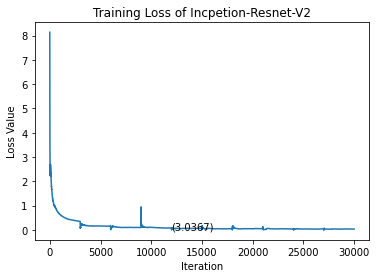

In [ ]:
# plot the accuracy and loss
loss_new = [item for item in history.losses if item is not None][1:]
print(loss_new)

y1_min=np.argmin(loss_new)
show_min='('+str(loss_new[y1_min])[:6]+')'



plt.annotate(show_min,xy=(y1_min,loss_new[y1_min]),xytext=(y1_min,loss_new[y1_min]))

plt.plot(loss_new)
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.title("Training Loss of Incpetion-Resnet-V2")
plt.show()

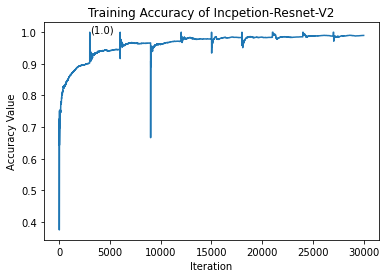

In [ ]:
# plot the accuracy and loss
y1_max=np.argmax(history.accuracy)
show_max='('+str(history.accuracy[y1_max])[:6]+')'



plt.annotate(show_max,xy=(y1_max,history.accuracy[y1_max]),xytext=(y1_max,history.accuracy[y1_max]))
plt.xlabel("Iteration")
plt.ylabel("Accuracy Value")
plt.title("Training Accuracy of Incpetion-Resnet-V2")
plt.plot(history.accuracy)
plt.show()

In [ ]:
# load pre-trained VGG model
vgg = keras.applications.VGG16(include_top=False, weights='imagenet')


In [ ]:
# fine-tuning
vgg_output = vgg.output
vgg_output = keras.layers.GlobalMaxPooling2D()(vgg_output)
vgg_output = keras.layers.Dense(2048, activation='relu')(vgg_output)
vgg_outputs = keras.layers.Dense(3, activation='softmax')(vgg_output)

In [ ]:
vgg_model = keras.Model(inputs=vgg.input, outputs=vgg_outputs)
vgg_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
# Lock pretrained parameters
for layer in vgg_model.layers:
  layer.trainable = False

for layer in vgg_model.layers[-5:]:
  print(layer)
  layer.trainable = True

# Compile
vgg_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics =['accuracy'])

In [ ]:
# Fit model
history1 = History()
vgg_model.fit(train, epochs=10, verbose=1, callbacks=[history1])
vgg_model.save('keras_vgg_weights.h5')

Epoch 1/10
3000/3000 [==============================] - 139s 46ms/step - loss: 0.3347 - accuracy: 0.9100
Epoch 2/10
3000/3000 [==============================] - 138s 46ms/step - loss: 0.2255 - accuracy: 0.9558
Epoch 3/10
3000/3000 [==============================] - 138s 46ms/step - loss: 0.1682 - accuracy: 0.9679
Epoch 4/10
3000/3000 [==============================] - 138s 46ms/step - loss: 0.1457 - accuracy: 0.9769
Epoch 5/10
3000/3000 [==============================] - 141s 47ms/step - loss: 0.1210 - accuracy: 0.9833
Epoch 6/10
3000/3000 [==============================] - 141s 47ms/step - loss: 0.1138 - accuracy: 0.9864
Epoch 7/10
3000/3000 [==============================] - 140s 47ms/step - loss: 0.1082 - accuracy: 0.9902
Epoch 8/10
3000/3000 [==============================] - 140s 47ms/step - loss: 0.0757 - accuracy: 0.9938
Epoch 9/10
3000/3000 [==============================] - 140s 47ms/step - loss: 0.0459 - accuracy: 0.9958
Epoch 10/10
3000/3000 [==============================] 

In [ ]:
# Evaluate
vgg_model.evaluate(val)

750/750 [==============================] - 746s 996ms/step - loss: 0.7943 - accuracy: 0.9567


[0.7943055033683777, 0.9566666483879089]

In [ ]:
from keras.preprocessing import image
import torch

def image_to_tensor(image_path):
  keras_image = image.load_img(image_path, target_size=(299, 299), color_mode='rgb')
  keras_image_tensor = image.img_to_array(keras_image)*(1.0/255.0)
  keras_image_tensor = np.asarray(torch.unsqueeze(torch.tensor(keras_image_tensor), 0))
  return keras_image_tensor

lung_scc_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg"
lung_n_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_n/lungn1000.jpeg"
lung_aca_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1000.jpeg"

vgg_model = keras.models.load_model('keras_vgg_weights.h5')

output1 = vgg_model.predict(image_to_tensor(lung_scc_image), batch_size=4)
output2 = vgg_model.predict(image_to_tensor(lung_n_image), batch_size=4)
output3 = vgg_model.predict(image_to_tensor(lung_aca_image), batch_size=4)
print(output1)
print(output2)
print(output3)

[[0. 0. 1.]]
[[0. 1. 0.]]
[[1.0000000e+00 2.2886607e-26 6.2951848e-18]]


[5.973845958709717, 16.318817138671875, 15.460284233093262, 12.647570610046387, 10.766024589538574, 9.352991104125977, 8.279928207397461, 7.513381004333496, 6.854238986968994, 6.248847484588623, 5.781222820281982, 5.376105785369873, 5.008533477783203, 4.739666938781738, 4.460907936096191, 4.255476951599121, 4.260826110839844, 4.059033393859863, 3.8623414039611816, 3.70255708694458, 3.5631492137908936, 3.449540615081787, 3.3764922618865967, 3.268533706665039, 3.1893773078918457, 3.0839383602142334, 2.9861295223236084, 2.891016721725464, 2.811608076095581, 2.7631547451019287, 2.73734974861145, 2.7360029220581055, 2.673853635787964, 2.6105527877807617, 2.559309244155884, 2.5040371417999268, 2.456174373626709, 2.4031660556793213, 2.3495278358459473, 2.294703245162964, 2.244464635848999, 2.194161891937256, 2.1559410095214844, 2.1208810806274414, 2.080275297164917, 2.0441887378692627, 2.0192267894744873, 2.0142428874969482, 1.9859386682510376, 1.956323504447937, 1.9334689378738403, 1.9068861

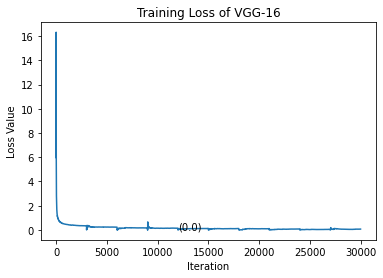

In [ ]:
# plot the accuracy and loss
loss_new = [item for item in history1.losses if item is not None][1:]
print(loss_new)

y1_min=np.argmin(loss_new)
show_min='('+str(loss_new[y1_min])[:6]+')'



plt.annotate(show_min,xy=(y1_min,loss_new[y1_min]),xytext=(y1_min,loss_new[y1_min]))

plt.plot(loss_new)
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.title("Training Loss of VGG-16")
plt.show()

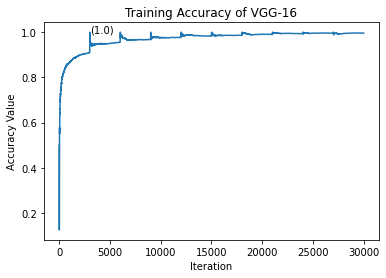

In [ ]:
# plot the accuracy and loss
y1_max=np.argmax(history1.accuracy)
show_max='('+str(history1.accuracy[y1_max])[:6]+')'



plt.annotate(show_max,xy=(y1_max,history1.accuracy[y1_max]),xytext=(y1_max,history1.accuracy[y1_max]))
plt.xlabel("Iteration")
plt.ylabel("Accuracy Value")
plt.title("Training Accuracy of VGG-16")
plt.plot(history1.accuracy)
plt.show()

In [ ]:
resnet = keras.applications.ResNet101V2(include_top=False, weights='imagenet')

171327488/171317808 [==============================] - 2s 0us/step


In [ ]:
# fine-tuning
resnet_output = resnet.output
resnet_output = keras.layers.GlobalMaxPooling2D()(resnet_output)
resnet_output = keras.layers.Dense(2048, activation='relu')(resnet_output)
resnet_outputs = keras.layers.Dense(3, activation='softmax')(resnet_output)

In [ ]:
resnet_model = keras.Model(inputs=resnet.input, outputs=resnet_outputs)
resnet_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Lock pretrained parameters
for layer in resnet_model.layers:
  layer.trainable = False

for layer in resnet_model.layers[-7:]:
  print(layer)
  layer.trainable = True

# Compile
resnet_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [ ]:
history2 = History()
resnet_model.fit(train, epochs=10, verbose=1, callbacks=[history2], shuffle=True)
resnet_model.save('keras_resnet_weights.h5')

Epoch 1/10
3000/3000 [==============================] - 161s 52ms/step - loss: 0.5536 - accuracy: 0.9028
Epoch 2/10
3000/3000 [==============================] - 155s 52ms/step - loss: 0.1416 - accuracy: 0.9491
Epoch 3/10
3000/3000 [==============================] - 155s 52ms/step - loss: 0.1103 - accuracy: 0.9598
Epoch 4/10
3000/3000 [==============================] - 153s 51ms/step - loss: 0.0705 - accuracy: 0.9747
Epoch 5/10
3000/3000 [==============================] - 154s 51ms/step - loss: 0.0596 - accuracy: 0.9793
Epoch 6/10
3000/3000 [==============================] - 154s 51ms/step - loss: 0.0542 - accuracy: 0.9843
Epoch 7/10
3000/3000 [==============================] - 155s 52ms/step - loss: 0.0429 - accuracy: 0.9864
Epoch 8/10
3000/3000 [==============================] - 154s 51ms/step - loss: 0.0377 - accuracy: 0.9896
Epoch 9/10
3000/3000 [==============================] - 154s 51ms/step - loss: 0.0312 - accuracy: 0.9902
Epoch 10/10
3000/3000 [==============================] 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
resnet_model.evaluate(val)

750/750 [==============================] - 40s 51ms/step - loss: 0.0519 - accuracy: 0.9840


[0.05187663435935974, 0.984000027179718]

In [ ]:
from keras.preprocessing import image
import torch

def image_to_tensor(image_path):
  keras_image = image.load_img(image_path, target_size=(299, 299), color_mode='rgb')
  keras_image_tensor = image.img_to_array(keras_image)*(1.0/255.0)
  keras_image_tensor = np.asarray(torch.unsqueeze(torch.tensor(keras_image_tensor), 0))
  return keras_image_tensor

lung_scc_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg"
lung_n_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_n/lungn1000.jpeg"
lung_aca_image = "/content/drive/MyDrive/msc_project/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1000.jpeg"

resnet_model = keras.models.load_model('keras_resnet_weights.h5')

resnet_output1 = resnet_model.predict(image_to_tensor(lung_scc_image), batch_size=4)
resnet_output2 = resnet_model.predict(image_to_tensor(lung_n_image), batch_size=4)
resnet_output3 = resnet_model.predict(image_to_tensor(lung_aca_image), batch_size=4)
print(resnet_output1)
print(resnet_output2)
print(resnet_output3)

[[3.6287038e-03 1.1490852e-14 9.9637127e-01]]
[[3.7014888e-22 1.0000000e+00 1.7090858e-35]]
[[0.9528951  0.03630719 0.01079763]]


[94.01758575439453, 67.40003204345703, 56.59245300292969, 53.80363845825195, 55.89836502075195, 57.18163299560547, 51.253143310546875, 47.685585021972656, 44.1453857421875, 40.39130401611328, 38.52872848510742, 36.81332015991211, 36.88854217529297, 35.51948928833008, 35.78798294067383, 33.97536087036133, 34.75688552856445, 32.92987823486328, 31.395828247070312, 29.962308883666992, 28.74529457092285, 28.166288375854492, 27.98261070251465, 27.13105010986328, 26.508087158203125, 25.658973693847656, 24.887285232543945, 24.062070846557617, 23.26020050048828, 22.681095123291016, 21.97258186340332, 21.306747436523438, 20.80219268798828, 20.313596725463867, 19.80377960205078, 19.26866340637207, 18.830015182495117, 18.347843170166016, 17.9811954498291, 17.621809005737305, 17.235136032104492, 17.061752319335938, 16.680557250976562, 16.355220794677734, 15.999671936035156, 15.6867094039917, 15.419144630432129, 15.10446834564209, 14.914495468139648, 14.817960739135742, 14.81685733795166, 14.5372934

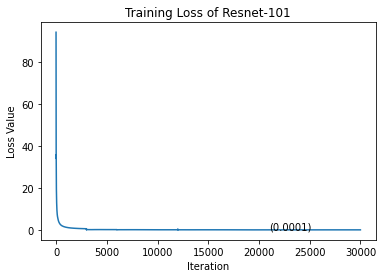

In [ ]:
# plot the accuracy and loss
loss_new_resnet = [item for item in history2.losses if item is not None][1:]
print(loss_new_resnet)

y1_min=np.argmin(loss_new_resnet)
show_min='('+str(loss_new_resnet[y1_min])[:6]+')'



plt.annotate(show_min,xy=(y1_min,loss_new_resnet[y1_min]),xytext=(y1_min,loss_new_resnet[y1_min]))

plt.plot(loss_new_resnet)
plt.xlabel("Iteration")
plt.ylabel("Loss Value")
plt.title("Training Loss of Resnet-101")
plt.show()

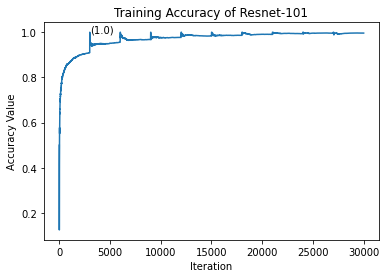

In [ ]:
# plot the accuracy and loss
y1_max=np.argmax(history2.accuracy)
show_max='('+str(history2.accuracy[y1_max])[:6]+')'



plt.annotate(show_max,xy=(y1_max,history2.accuracy[y1_max]),xytext=(y1_max,history2.accuracy[y1_max]))
plt.xlabel("Iteration")
plt.ylabel("Accuracy Value")
plt.title("Training Accuracy of Resnet-101")
plt.plot(history1.accuracy)
plt.show()

# Ensemble Model

In [ ]:
# load models
inception_resnet_path = "/content/drive/MyDrive/msc_project/keras_inception_resnet_v2_weights.h5"
vgg16_path = "/content/drive/MyDrive/msc_project/keras_vgg_weights.h5"
resnet101_path = "/content/drive/MyDrive/msc_project/keras_resnet_weights.h5"

In [ ]:
resnet_model = keras.models.load_model(resnet101_path)
vgg_model = keras.models.load_model(vgg16_path)
inception_resnet_model = keras.models.load_model(inception_resnet_path)

In [10]:
history_test1, history_test2, history_test3 = [], [], []
resnet_test = resnet_model.evaluate(val, callbacks=[history_test1])
vgg_test = vgg_model.evaluate(val, callbacks=[history_test2])
inception_resnet_test = inception_resnet_model.evaluate(val, callbacks=[history_test3])


750/750 [==============================] - 48s 60ms/step - loss: 0.0364 - accuracy: 0.9857


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(len(val))
print(val.samples)

750
3000


In [ ]:
double_data = val.next()
image_data = double_data[0]
image_label = double_data[1]
print(image_label)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# single test
resnet_result = resnet_model(image_data)
vgg_result = vgg_model(image_data)
inception_result = inception_resnet_model(image_data)
print(resnet_result)
print(vgg_result)
print(inception_result)

tf.Tensor(
[[9.9743503e-01 9.1901119e-04 1.6460181e-03]
 [9.9999106e-01 8.9339092e-06 2.2641167e-08]
 [1.4578186e-16 1.0000000e+00 9.1118830e-30]
 [3.5831818e-18 1.0000000e+00 0.0000000e+00]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[1.0000000e+00 0.0000000e+00 2.8946962e-25]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 0.0000000e+00]], shape=(4, 3), dtype=float32)
tf.Tensor(
[[9.9666840e-01 4.5636894e-05 3.2859908e-03]
 [9.9999917e-01 3.0651686e-12 8.7976247e-07]
 [6.4624306e-10 1.0000000e+00 9.0582307e-16]
 [1.4607379e-07 9.9999988e-01 7.5163721e-12]], shape=(4, 3), dtype=float32)


In [ ]:
from collections import defaultdict
def ensemble_predict(resnet_array, vgg_array, inception_array):
  final_result = np.zeros((4, 3))
  for i in range(len(resnet_array)):
    # print(str(i)+"==============")
    vote_array = np.zeros(3)
    vote_array[np.argmax(resnet_array[i])] += 1
    vote_array[np.argmax(vgg_array[i])] += 1
    vote_array[np.argmax(inception_array[i])] += 1
    # print(vote_array)
    final_result[i][np.argmax(vote_array)] += 1
    
    
  
  return final_result
    
single_result = ensemble_predict(resnet_result, vgg_result, inception_result)
print(single_result)


[[1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
# prediction accuracy of ensemble model
def ensemble_model_test(val):
  correct_num = val.samples
  for item in val:
    image_data = item[0]
    image_label = item[1]
    resnet_result = resnet_model(image_data)
    vgg_result = vgg_model(image_data)
    inception_result = inception_resnet_model(image_data)
    ensemble_result = ensemble_predict(resnet_result, vgg_result, inception_result)
    for i in range(len(ensemble_result)):
      if np.argmax(ensemble_result[i]) != np.argmax(image_label[i]):
        correct_num -= 1
      print("correct rate:", correct_num / val.samples)
  return correct_num / val.samples




ensemble_model_test(val)